<a href="https://colab.research.google.com/github/KaylumCassidy/BMCA3/blob/main/Copy_of_DATA4001FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATA4001 Final Project Image-Based Video Game Classification with Deep Neural Networks

In this project, we aim to develop a deep learning model that can automatically classify video games into their respective games based on images or visual content. Video game genre classification is a valuable application of computer vision and deep learning, with potential uses in recommendation systems, content tagging, and more. The project will focus on leveraging deep learning techniques to accurately identify and classify video game genres from in-game screenshots or cover art.

##  Importing Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import random
import shutil

In [ ]:

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import itertools
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [ ]:
pip install split-folders


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import splitfolders
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Importing data via Kaggle API

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aditmagotra/gameplay-images


100% 2.50G/2.51G [02:13<00:00, 17.4MB/s]
100% 2.51G/2.51G [02:13<00:00, 20.1MB/s]


In [ ]:
!ls /content/


gameplay-images.zip  kaggle.json  sample_data


In [ ]:
!unzip "gameplay-images.zip" -d /content/my-dataset

In [ ]:
import os

# Specify the directory where your dataset is located
dataset_directory = 'my-dataset/Dataset'

# List the contents of the dataset directory
contents = os.listdir(dataset_directory)

# Print the contents
for item in contents:
    if os.path.isdir(os.path.join(dataset_directory, item)):
        print(f"Directory: {item}/")
    else:
        print(f"File: {item}")

Directory: God of War/
Directory: Forza Horizon/
Directory: Free Fire/
Directory: Terraria/
Directory: Minecraft/
Directory: Apex Legends/
Directory: Among Us/
Directory: Roblox/
Directory: Genshin Impact/
Directory: Fortnite/


## Divide our dataset into train and val

In [ ]:
data_dir = 'my-dataset'
splitfolders.ratio('my-dataset/Dataset', output=data_dir, seed=1337, ratio=(0.8, 0.2, 0))

Copying files: 10000 files [00:05, 1821.26 files/s]


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop a portion of the image and resize it to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop a 224x224 portion from the center of the image
        transforms.ToTensor(),  # Convert the image to a torch.FloatTensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['val']}")
print(f"The notebook is running on {device}")


Train size: 8000
Validation size: 2000
The notebook is running on cuda:0


## Putting data in a dataframe

In [ ]:
import glob

# Define the directory path to your gameplay data
path = 'my-dataset/Dataset'

# Use glob to list all .jpg files in the specified directory and its subdirectories
path_imgs = list(glob.glob(path + '/**/*.png', recursive=True))

# Extract labels from the file paths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_imgs))

# Create a Pandas Series for file paths and labels
file_path = pd.Series(path_imgs, name='File_Path', dtype=str)
labels = pd.Series(labels, name='Labels', dtype=str)

# Create a DataFrame by concatenating the file paths and labels
data = pd.concat([file_path, labels], axis=1)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
data.head()

,File_Path,Labels
0,my-dataset/Dataset/Genshin Impact/image_165.png,Genshin Impact
1,my-dataset/Dataset/God of War/image_889.png,God of War
2,my-dataset/Dataset/Apex Legends/image_277.png,Apex Legends
3,my-dataset/Dataset/Terraria/image_922.png,Terraria
4,my-dataset/Dataset/Terraria/image_48.png,Terraria


In [ ]:
data_dir = 'my-dataset/Dataset'
# Generate data paths with labels
ds_name = 'Games'
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [ ]:
df.head()

,filepaths,labels
0,my-dataset/Dataset/God of War/image_969.png,God of War
1,my-dataset/Dataset/God of War/image_54.png,God of War
2,my-dataset/Dataset/God of War/image_467.png,God of War
3,my-dataset/Dataset/God of War/image_389.png,God of War
4,my-dataset/Dataset/God of War/image_986.png,God of War


## EDA & Data Visualization

In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Games dataset has 10000 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Games dataset has 10 classes


In [ ]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Games dataset has: 

Class 'God of War' has 1000 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 1000 images
----------------------------------------------------------------------
Class 'Free Fire' has 1000 images
----------------------------------------------------------------------
Class 'Terraria' has 1000 images
----------------------------------------------------------------------
Class 'Minecraft' has 1000 images
----------------------------------------------------------------------
Class 'Apex Legends' has 1000 images
----------------------------------------------------------------------
Class 'Among Us' has 1000 images
----------------------------------------------------------------------
Class 'Roblox' has 1000 images
----------------------------------------------------------------------
Class 'Genshin Impact' has 1000 images
----------------------------------------------------------------------
Class 'Fortnite' has 1

In [ ]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Games dataset has no null values


In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

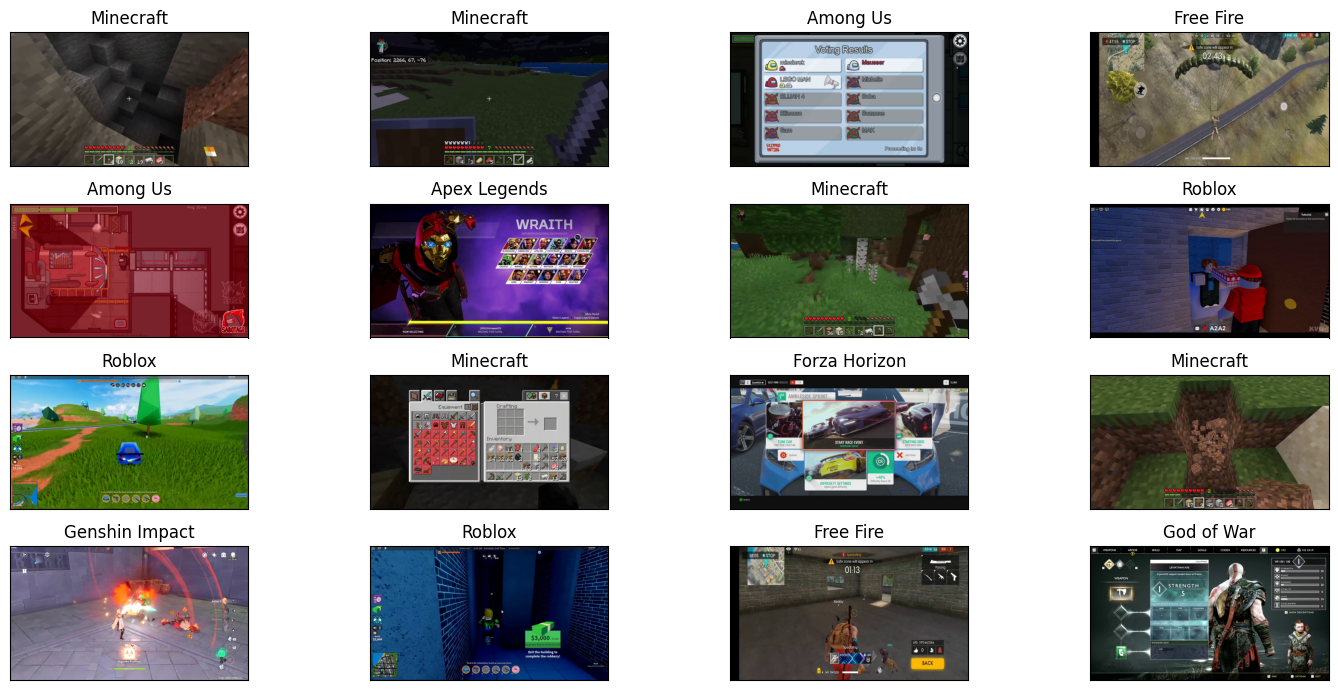

In [ ]:


# Define the number of rows and columns in the grid
nrows = 4
ncols = 4

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display images with labels
for i, ax in enumerate(axes.flat):
    if i < len(data):
        # Load and display an image from the 'File_Path' and set the title as 'Labels'
        ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
        ax.set_title(data.Labels[i])  # Set the title as the label
    else:
        # If there are no more images in the dataset, remove the empty subplot
        fig.delaxes(ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


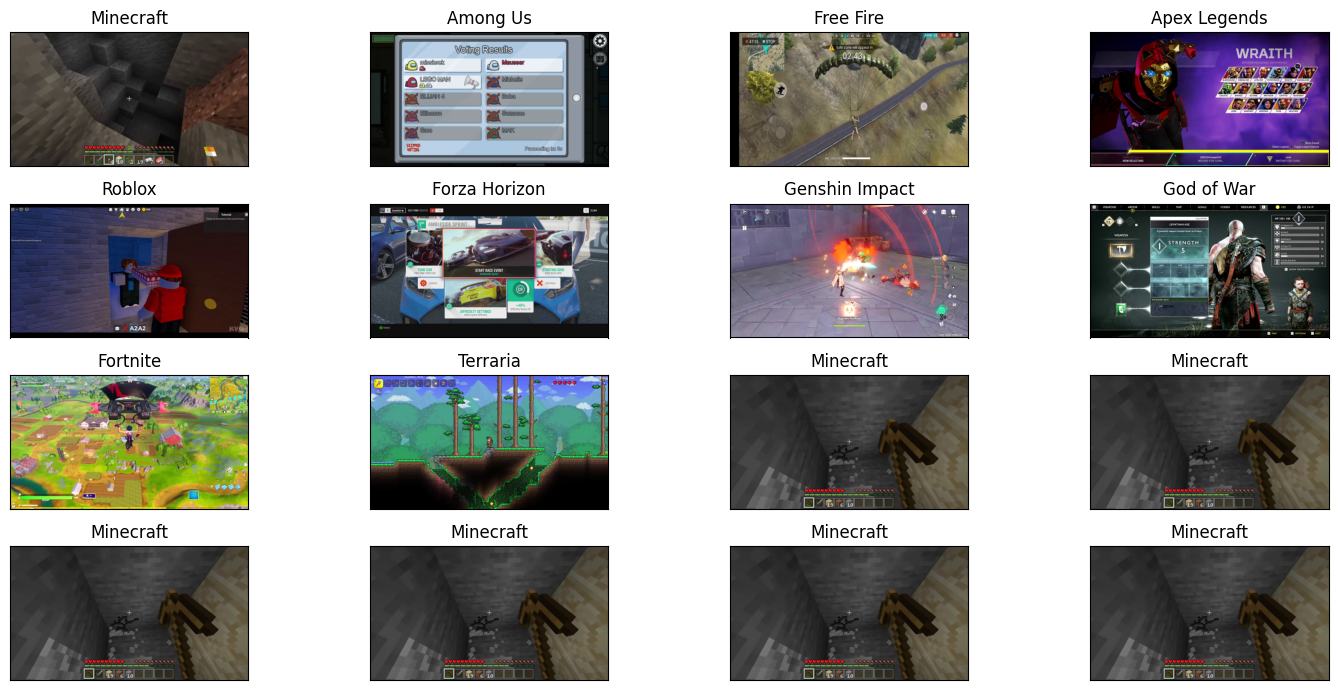

In [ ]:


# Create a list to keep track of seen game classes
seen_classes = set()

# Create a 4x4 grid of subplots for visualization
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

# Loop through the subplots and display one image from each game class
for i, ax in enumerate(axes.flat):
    # Find the next image with a new game class
    while data.Labels[i] in seen_classes and i < len(data) - 1:
        i += 1

    # Add the current game class to the set of seen classes
    seen_classes.add(data.Labels[i])

    # Load and display the selected image from the 'File_Path'
    ax.imshow(plt.imread(data.File_Path[i]))  # Display the image
    ax.set_title(data.Labels[i])  # Set the title as the label

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


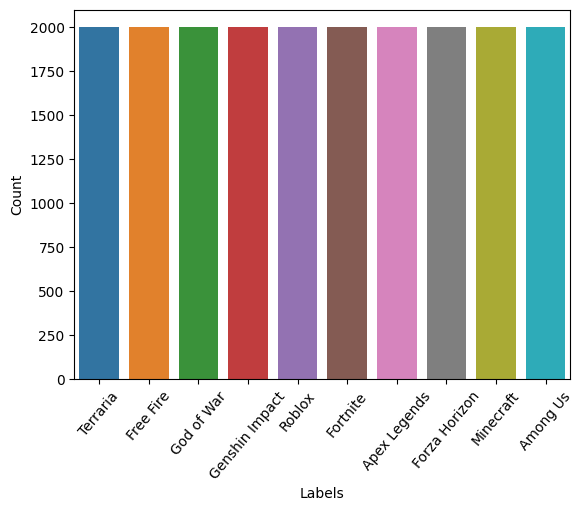

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

All data seen to be find and able to use


###images after augmentations

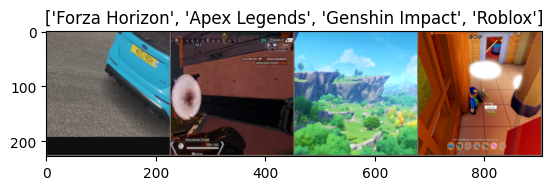

In [ ]:
# Define the imshow function
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause for updating

# Get a batch from the 'train' dataloader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Display the images and their corresponding class labels
imshow(out, title=[class_names[x] for x in classes])

## Computing Error Rate Analysi

The code below is used for error level analysis (ELA) of images in the context of a game image classification task.

In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from keras.layers import Dense, Dropout

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

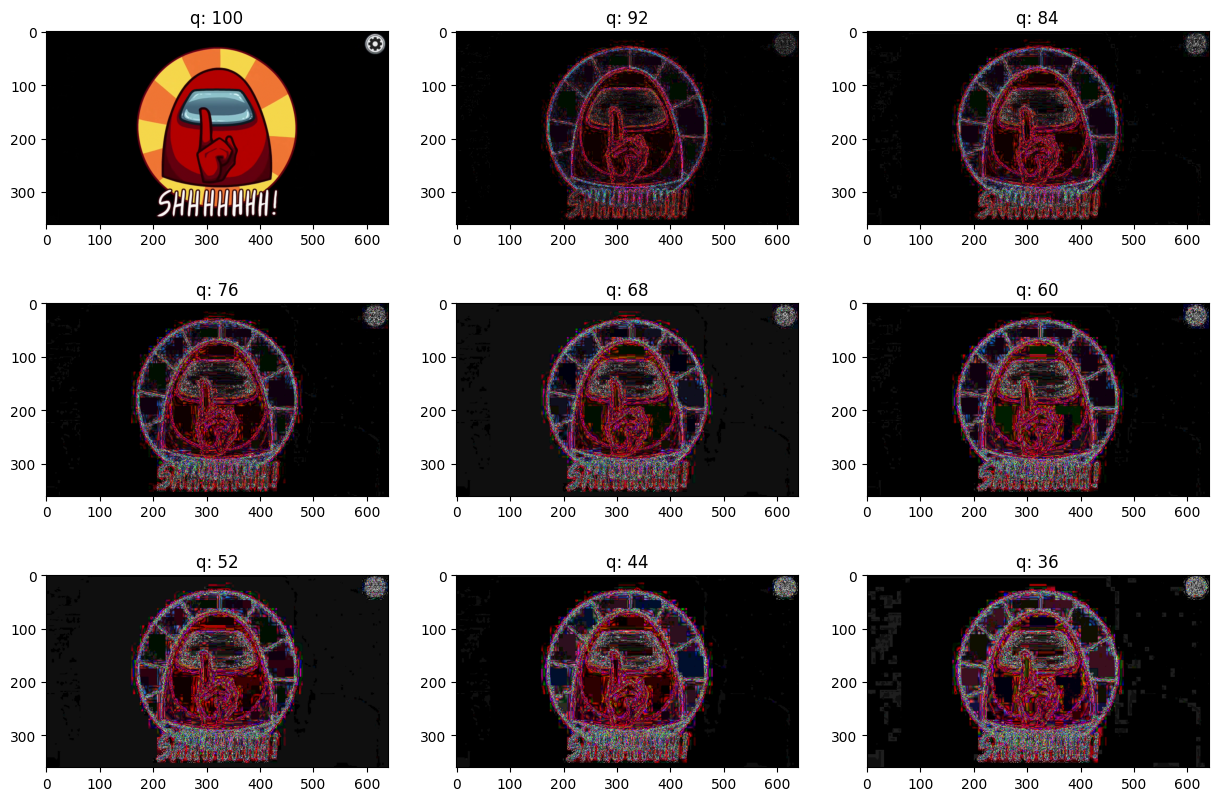

In [ ]:
# View random sample from the dataset
p = random_sample('my-dataset/Dataset/Among Us')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Overall, this code provides a way to visually analyze the effect of different levels of JPEG compression on gaming images, and may be used to identify optimal quality levels for image compression in the context of a game image classification task.

## Train & Test Split

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Games dataset has 10 classes
The Validation Games dataset has 10 classes
The Testing Games dataset has 10 classes


In [ ]:
classes_count(train_df, 'Training '+ds_name)

The Training Games dataset has: 

Class 'Fortnite' has 815 images
----------------------------------------------------------------------
Class 'Roblox' has 796 images
----------------------------------------------------------------------
Class 'God of War' has 792 images
----------------------------------------------------------------------
Class 'Apex Legends' has 785 images
----------------------------------------------------------------------
Class 'Free Fire' has 788 images
----------------------------------------------------------------------
Class 'Genshin Impact' has 798 images
----------------------------------------------------------------------
Class 'Terraria' has 821 images
----------------------------------------------------------------------
Class 'Minecraft' has 810 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 795 images
----------------------------------------------------------------------
Class 'Among Us' has 8

In [ ]:
classes_count(valid_df, 'Val '+ds_name)

The Val Games dataset has: 

Class 'Genshin Impact' has 127 images
----------------------------------------------------------------------
Class 'God of War' has 115 images
----------------------------------------------------------------------
Class 'Among Us' has 123 images
----------------------------------------------------------------------
Class 'Free Fire' has 122 images
----------------------------------------------------------------------
Class 'Apex Legends' has 124 images
----------------------------------------------------------------------
Class 'Fortnite' has 116 images
----------------------------------------------------------------------
Class 'Forza Horizon' has 127 images
----------------------------------------------------------------------
Class 'Roblox' has 126 images
----------------------------------------------------------------------
Class 'Minecraft' has 124 images
----------------------------------------------------------------------
Class 'Terraria' has 96 ima

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

## Fuctions

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # There are training and validation phases in each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through batches of data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the model
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate accuracy and loss for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Update the learning rate in the training phase
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f} min {time_elapsed % 60:.0f} sec')
    print(f'Best accuracy on validation: {best_acc:4f}')

    # Load the weights of the best model
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split your 'data' DataFrame into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# Define your data augmentation and generator function
def create_data_generators(preprocessing_function, train, test):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',  # Adjust this to match your column names
        y_col='Labels',  # Adjust this to match your column names
        target_size=(100, 100),  # Adjust the target size as needed
        color_mode='rgb',
        class_mode='categorical',  # Depending on your labels
        batch_size=32,
        verbose=0,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

# Assuming 'File_Path' is the correct column name for file paths
def create_data_generators(train, test):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100, 100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

# Split your 'data' DataFrame into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

# Create data generators with your preprocessing function and dataframes
train_gen, valid_gen, test_gen = create_data_generators(train_df, test_df)


Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


### Visualizing Model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


##Visualize Training dataset

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

NameError: ignored

## Method 1: Finetuning for Convolutional Networks

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
out_ftrs = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, out_ftrs)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for the entire model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.8164 Acc: 0.7410
val Loss: 0.1496 Acc: 0.9565

Epoch 1/5
----------
train Loss: 0.5076 Acc: 0.8385
val Loss: 0.0957 Acc: 0.9730

Epoch 2/5
----------
train Loss: 0.4371 Acc: 0.8662
val Loss: 0.0654 Acc: 0.9780

Epoch 3/5
----------
train Loss: 0.3555 Acc: 0.8850
val Loss: 0.0758 Acc: 0.9775

Epoch 4/5
----------
train Loss: 0.3285 Acc: 0.9002
val Loss: 0.0601 Acc: 0.9840

Epoch 5/5
----------
train Loss: 0.3157 Acc: 0.9026
val Loss: 0.0602 Acc: 0.9830

Training complete in 5 min 49 sec
Best accuracy on validation: 0.984000


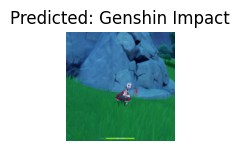

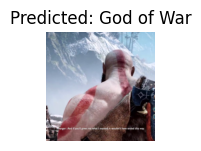

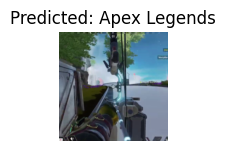

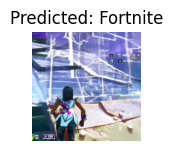

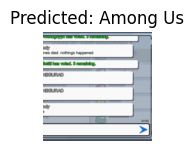

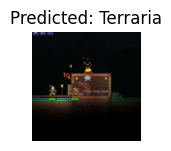

In [ ]:
visualize_model(model_ft)

### Saving model for later use

In [ ]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)

# Now your model is saved at model_save_path


In [ ]:

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)


In [ ]:
model_save_path = 'model.pth'

# Save the model's state dictionary
torch.save(model_ft.state_dict(), model_save_path)


### Testing the Acc of Gameplay images classification  

In [ ]:
import torch
from torchvision import transforms

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Resize and crop as per your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])




In [ ]:
# Load and preprocess the input image
from PIL import Image
img_path = 'my-dataset/Dataset/Roblox/image_103.png'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension
# Move the input tensor to the same device as the model
img = img.to(device)


# Set the model to evaluation mode
model_ft.eval()

# Perform inference
with torch.no_grad():
    outputs = model_ft(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [ ]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")


Predicted Label: Terraria


## Method 2: Convolutional Network as a Frozen Feature Extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze the parameters
for param in model_conv.parameters():
    param.requires_grad = False

# The new fully connected layer has requires_grad=True by default
num_ftrs = model_conv.fc.in_features
out_ftrs = len(class_names)
model_conv.fc = nn.Linear(num_ftrs, out_ftrs)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Update weights for only the fully connected layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 1.0696 Acc: 0.6489
val Loss: 0.3773 Acc: 0.8795

Epoch 1/5
----------
train Loss: 0.7670 Acc: 0.7545
val Loss: 0.2643 Acc: 0.9160

Epoch 2/5
----------
train Loss: 0.7386 Acc: 0.7618
val Loss: 0.2645 Acc: 0.9125

Epoch 3/5
----------
train Loss: 0.7047 Acc: 0.7755
val Loss: 0.2335 Acc: 0.9240

Epoch 4/5
----------
train Loss: 0.6952 Acc: 0.7728
val Loss: 0.2402 Acc: 0.9240

Epoch 5/5
----------
train Loss: 0.6663 Acc: 0.7835
val Loss: 0.2067 Acc: 0.9285

Training complete in 5 min 51 sec
Best accuracy on validation: 0.928500


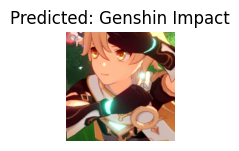

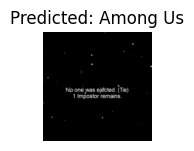

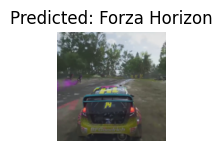

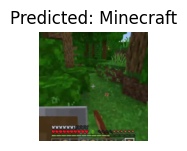

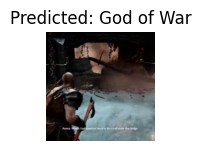

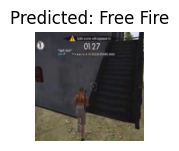

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Saving model

In [ ]:
import os

# Define the directory where you want to save the model
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'your_model_2.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(model_conv.state_dict(), model_save_path)

# Now your model is saved at model_save_pat

### Testing model

In [ ]:
# Load and preprocess the input image
from PIL import Image
img_path = 'my-dataset/Dataset/Roblox/image_103.png'
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension
# Move the input tensor to the same device as the model
img = img.to(device)


# Set the model to evaluation mode
model_conv.eval()

# Perform inference
with torch.no_grad():
    outputs = model_conv(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

In [ ]:
class_names = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: Terraria


## Method 3: EfficientNetB7

### Method 1

In [ ]:
pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00


In [ ]:
# Import the EfficientNetB7 model from timm library
import timm

# Define the EfficientNetB7 model
model_name = 'tf_efficientnet_b7'
pre_model = timm.create_model(model_name, pretrained=True)

# Adjust the input size for EfficientNetB7
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((600, 600)),  # Adjust input size for EfficientNetB7
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the number of video game genres (classes)
num_classes = 10  # Update with the number of classes in your dataset

# Modify the model architecture for EfficientNetB7
from torch import nn

pre_model = timm.create_model(model_name, pretrained=True)
pre_model.classifier = nn.Linear(pre_model.classifier.in_features, num_classes)

# Continue with data preprocessing and splitting as in your existing code

# Define the data preprocessing transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(600),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(600),
        transforms.CenterCrop(600),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

In [ ]:

num_epochs = 25
# Define the optimizer and loss function
optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
l
model_save_dir = 'model'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Define the filename for your model
model_filename = 'efficientnetb7_model.pth'

# Combine the directory and filename to create the full model path
model_save_path = os.path.join(model_save_dir, model_filename)

# Save the model's state dictionary
torch.save(pre_model.state_dict(), model_save_path)



In [ ]:
from PIL import Image
img_path = '/content/Apex-Legends-Mobile_6bwXO9o.webp'  # Replace with the path to your sample image
img = Image.open(img_path)
img = preprocess(img)
img = img.unsqueeze(0)  # Add a batch dimension

# Perform inference
pre_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = pre_model(img)

# Get the predicted class
_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

# Define the class names for your dataset
class_names = ["Among Us", "Apex Legends", "Fortnite", "Forza Horizon", "Free Fire", "Genshin Impact", "God of War", "Minecraft", "Roblox", "Terraria"]

# Get the predicted label
predicted_label = class_names[predicted_class]
print(f"Predicted Label: {predicted_label}")

Predicted Label: God of War


### Method 2

Generic Model Creation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1000, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(64, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 13s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1000)              2561000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               128128    
                                                      

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

Train Model

In [ ]:

batch_size = 64   # set batch size for training
epochs = 20   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/20
200/200 [==============================] - 103s 349ms/step - loss: 25.3078 - accuracy: 0.3356 - val_loss: 17.7600 - val_accuracy: 0.7200
Epoch 2/20
200/200 [==============================] - 64s 321ms/step - loss: 14.0459 - accuracy: 0.5831 - val_loss: 10.2213 - val_accuracy: 0.8294
Epoch 3/20
200/200 [==============================] - 64s 322ms/step - loss: 8.3550 - accuracy: 0.7164 - val_loss: 6.3378 - val_accuracy: 0.8425
Epoch 4/20
200/200 [==============================] - 64s 321ms/step - loss: 5.4713 - accuracy: 0.7917 - val_loss: 4.2876 - val_accuracy: 0.8888
Epoch 5/20
200/200 [==============================] - 65s 323ms/step - loss: 3.9122 - accuracy: 0.8347 - val_loss: 3.1408 - val_accuracy: 0.9100
Epoch 6/20
200/200 [==============================] - 64s 321ms/step - loss: 2.9834 - accuracy: 0.8650 - val_loss: 2.4537 - val_accuracy: 0.9119
Epoch 7/20
200/200 [==============================] - 64s 322ms/step - loss: 2.4190 - accuracy: 0.8811 - val_loss: 2.0179 - v

Plot accuarcy and loss curve

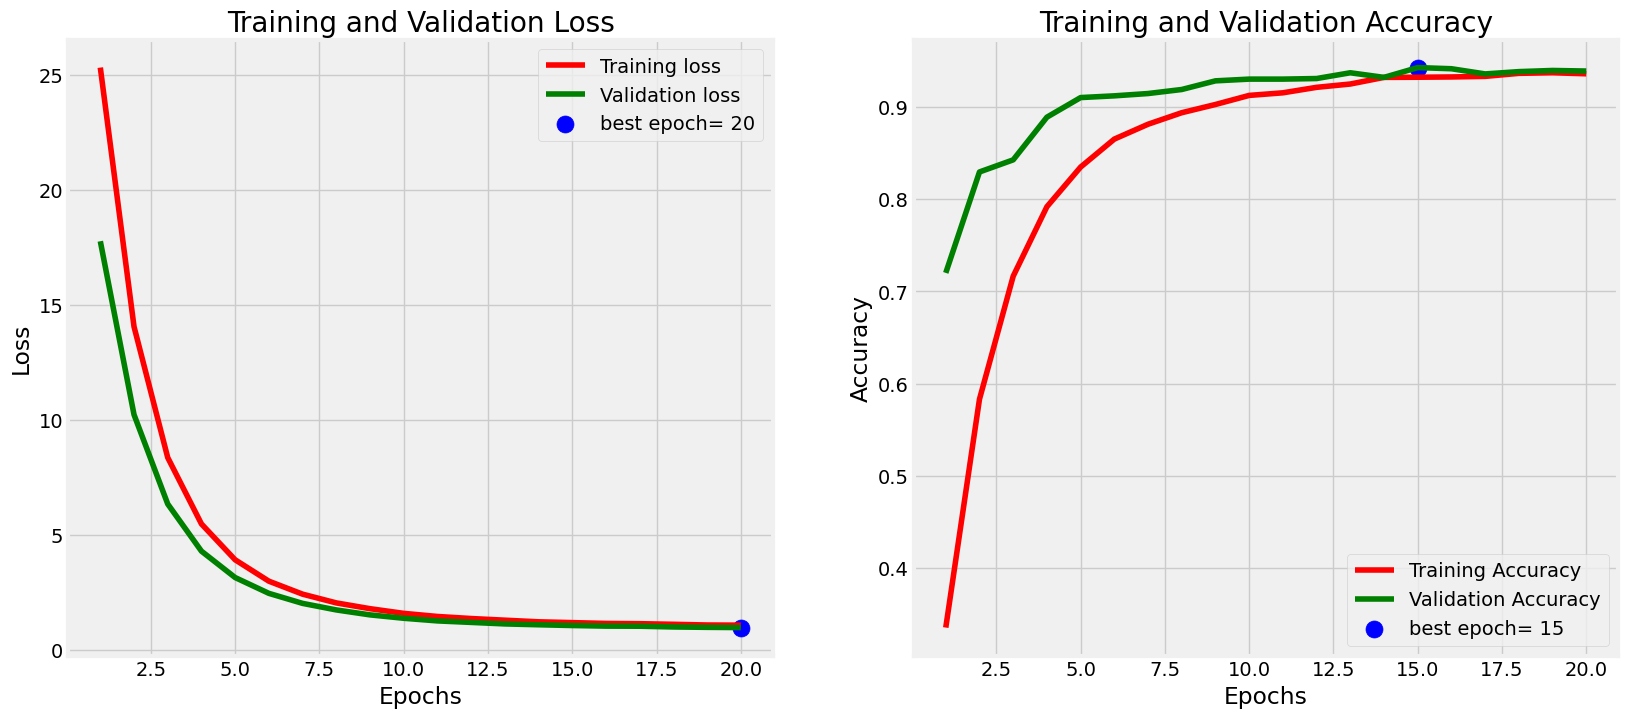

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuarcy

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 7s 262ms/step - loss: 0.9891 - accuracy: 0.9250
Train Loss:  0.862963080406189
Train Accuracy:  0.9762499928474426
--------------------
Validation Loss:  0.9769907593727112
Validation Accuracy:  0.9412500262260437
--------------------
Test Loss:  0.9890550971031189
Test Accuracy:  0.925000011920929


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confussion Matrix

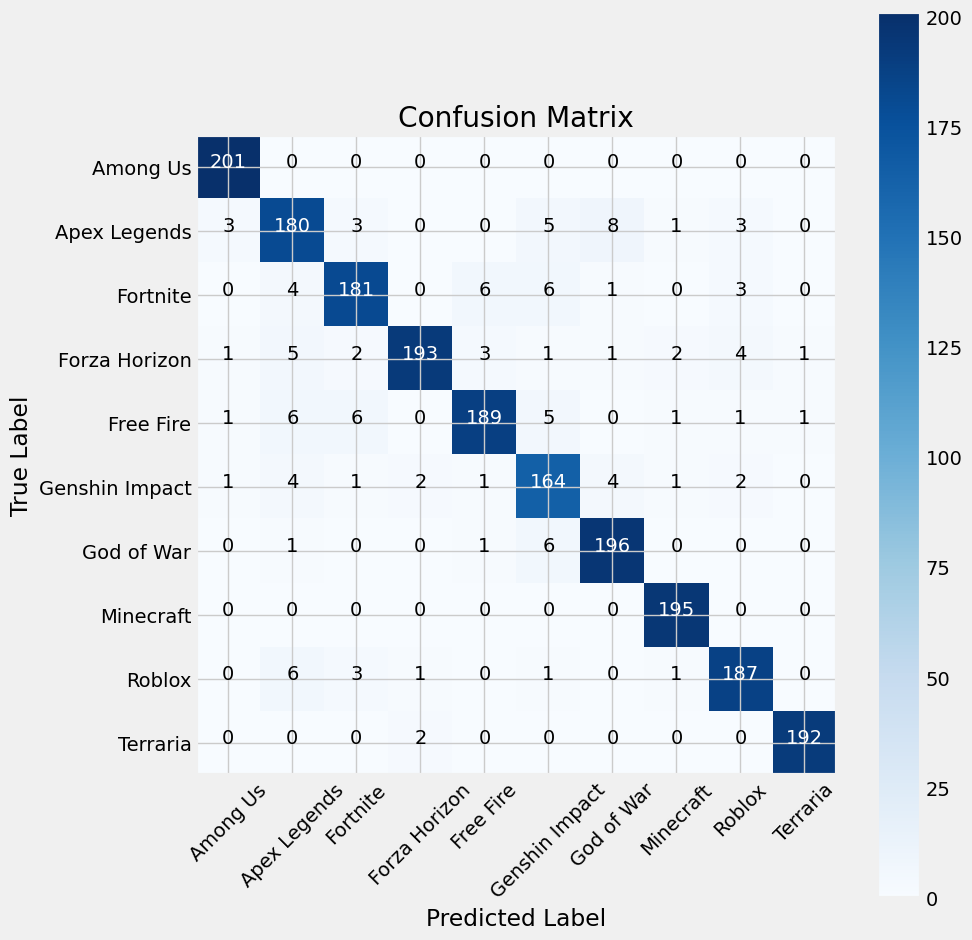

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

      Among Us       0.97      1.00      0.99       201
  Apex Legends       0.87      0.89      0.88       203
      Fortnite       0.92      0.90      0.91       201
 Forza Horizon       0.97      0.91      0.94       213
     Free Fire       0.94      0.90      0.92       210
Genshin Impact       0.87      0.91      0.89       180
    God of War       0.93      0.96      0.95       204
     Minecraft       0.97      1.00      0.98       195
        Roblox       0.94      0.94      0.94       199
      Terraria       0.99      0.99      0.99       194

      accuracy                           0.94      2000
     macro avg       0.94      0.94      0.94      2000
  weighted avg       0.94      0.94      0.94      2000



In [ ]:
model.save_weights('my_model_weights.h5')

Load the model and Predict the Inputs

1/1 [==============================] - 2s 2s/step


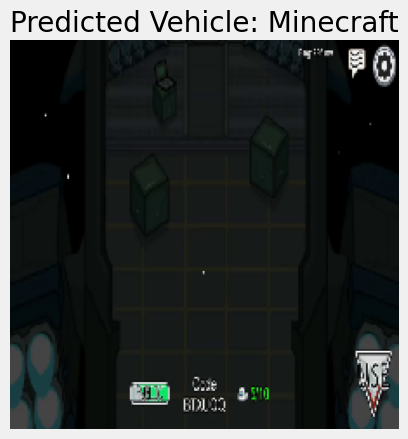

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ["Minecraft", "Roblox","Among Us", "God of War","Apex Legends","Forza Horizon","Free Fire","Genshin Impact","Terraria"]

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = 'my-dataset/Dataset/Among Us/image_0.png'
predict_and_display(image_path_to_test, model, class_labels)

image Classificaation using SVM is very efficient way of modelling and very rarely used algorithm for image processing and modelling

## Method 4: MoblieNet